## Hierarchical Wasserstein Alignment

_Aim:_ Decompose data into potential clusters and then find global alignment across two datasets by leveraging clustering structure.

_Paper describing HiWA:_ John Lee, Max Dabagia, E Dyer, C Rozell: Hierarchical Wasserstein Alignment for Multimodal Distributions, May 2019.

#### In this demo:

- Dimensionality reduction to first simplify problem
- Clustering in original and new dataset
- Alignment between clusters and then global alignment

In [1]:
# Import some necessary packages
import numpy as np
from src import utils, hiwa
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import Isomap
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Example A - Motor cortex during reaching movements (NHP)
_Data collected by:_ Matthew Perich, Lee Miller Lab (Northwestern)

#### Step 1. Apply initial dimensionality reduction

In [2]:
# Load the datasets from a .mat file
T_te, T_tr, X_te, X_tr, Y_te, Y_tr = utils.load_data('mihi_demo.mat')

# Apply initial dimensionality reduction (n_components)
Y_te_3d = FactorAnalysis(n_components=3).fit_transform(utils.remove_const_cols(Y_te))
X_tr_3d = utils.map_X_3D(X_tr)
X_transform = np.linalg.pinv(X_tr_3d) @ X_tr

#### Step 2. Align data with HiWA

In [3]:
# Fit the model and transform the source dataset
t1 = time.time()

# This indicates to the model it should compute a low-d embedding with isomap, and that the parameter datasets will not be normalized
hwa = hiwa.HiWA(dim_red_method=Isomap(n_components=2), normal=True)

# Fit the model, also passing in the correct rotation in Rgt since we can calculate it in this case (for computing error metrics)
# Note that we can provide the low-d mapping for either the source or target; the model will calculate whatever isn't provided
hwa.fit(Y_te_3d, T_te.squeeze(), X_tr_3d, T_tr.squeeze(), Y_transform=X_transform, Rgt=utils.LS_oracle(utils.map_X_3D(X_te), Y_te_3d))

# Transform the dataset with the learned rotation
Y_te_rec = hwa.transform(Y_te_3d)
t2 = time.time()
print('Time elapsed = ', t2 - t1, 'seconds')

# Evaluate decoding accuracy after alignment
r2_hwa = utils.eval_R2(Y_te_rec, utils.map_X_3D(X_te))
print('R2 Value = ', r2_hwa)


Time elapsed =  19.683264017105103 seconds
R2 Value =  0.455159922281


#### Step 3. Visualize results

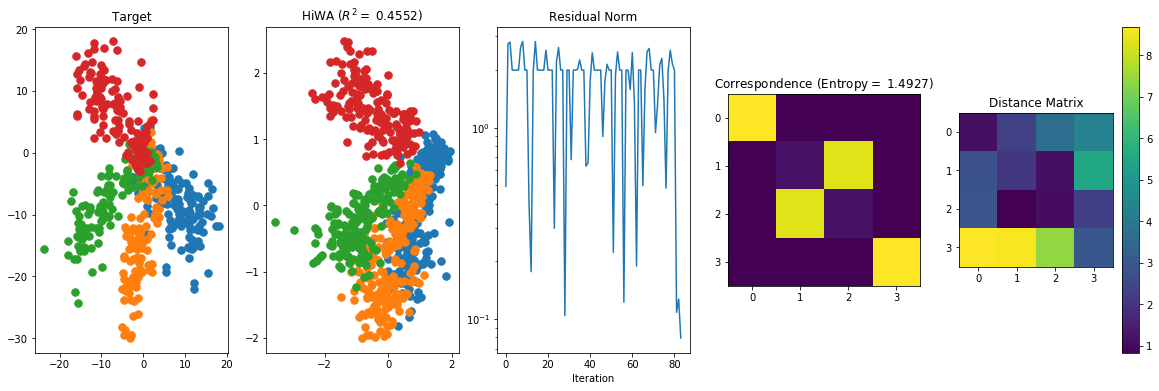

In [4]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(20, 6))
plt.subplot(1, 5, 1)
plt.title('Target')
utils.color_data(X_tr, T_tr.squeeze())
plt.subplot(1, 5, 2)
plt.title('HiWA ($R^2 = $ %.4f)' %r2_hwa)
utils.color_data(Y_te_rec, T_te.squeeze())
ax = plt.subplot(1, 5, 3)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(1, 5, 4)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(1, 5, 5)
plt.title('Distance Matrix')
plt.imshow(hwa.diagnostics['C'])
c = plt.colorbar()

### Example B - Neural recordings from rat dorsal striatum over a 24 hour period
_Data collected by_: Sam Funderburk, Keith Hengen Lab (WUSL)

#### Step 0. Load data

In [5]:
# Load the datasets from a numpy archive
with np.load('sleep_day1_60s.npz') as day1z:
    ft1 = day1z['firing_times_d1']
    l1 = day1z['labels_d1']
with np.load('sleep_day2_60s.npz') as day2z:
    ft2 = day2z['firing_times_d2']
    l2 = day2z['labels_d2']

#### Step 1. Dimensionality reduction

In [6]:
# Apply initial dimensionality reduction
pca = PCA(n_components=3)
ft1_3d = pca.fit_transform(ft1)
ft2_3d = pca.fit_transform(ft2)

#### Step 2. Align datasets with HiWA

In [7]:
# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normal=True)
ft1_rec = hwa.fit_transform(ft1_3d, l1, ft2_3d, l2)
t2 = time.time()

print('Time elapsed = ', t2 - t1, 'seconds')

Time elapsed =  11.055976867675781 seconds


#### Step 3. Visualize results

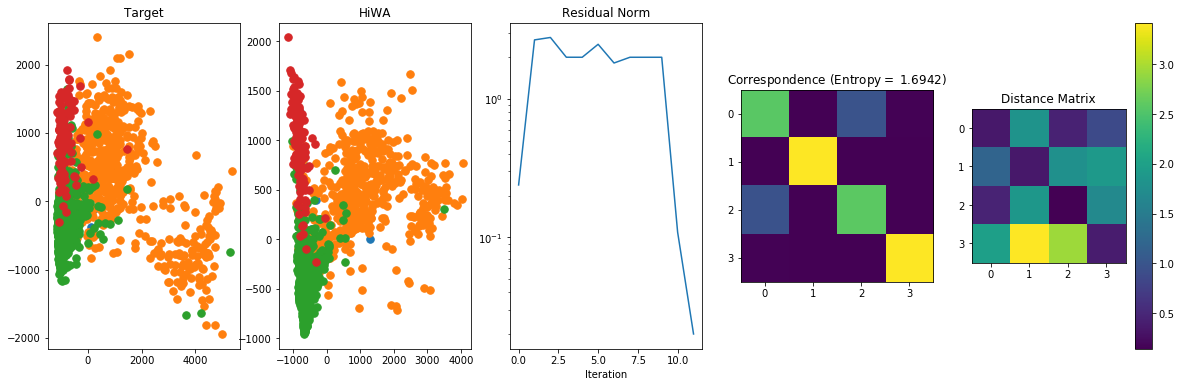

In [8]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(20, 6))
plt.subplot(1, 5, 1)
plt.title('Target')
utils.color_data(ft2_3d, l2)
plt.subplot(1, 5, 2)
plt.title('HiWA')
utils.color_data(ft1_rec, l1)
ax = plt.subplot(1, 5, 3)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(1, 5, 4)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(1, 5, 5)
plt.title('Distance Matrix')
plt.imshow(hwa.diagnostics['C'])
c = plt.colorbar()

#### Step 4. Try to first embed data in 5D and then solve matching in 2D

In [9]:
# We're not limited to matching in 3D
pca = PCA(n_components=5)
ft1_5d = pca.fit_transform(ft1)
ft2_5d = pca.fit_transform(ft2)

# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normal=True)
ft2_rec = hwa.fit_transform(ft2_5d, l2, ft1_5d, l1)
t2 = time.time()
print('Time elapsed = ', t2 - t1, 'seconds')

Time elapsed =  26.591480016708374 seconds


#### Step 5. Visualize results 

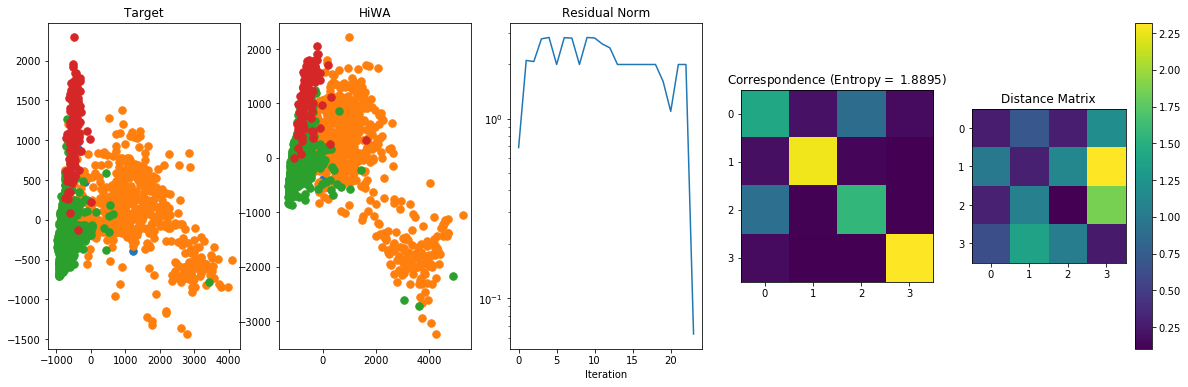

In [10]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(20, 6))
plt.subplot(1, 5, 1)
plt.title('Target')
utils.color_data(ft1_5d[:, 0:2], l1)
plt.subplot(1, 5, 2)
plt.title('HiWA')
utils.color_data(ft2_rec[:, 0:2], l2)
ax = plt.subplot(1, 5, 3)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(1, 5, 4)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(1, 5, 5)
plt.title('Distance Matrix')
plt.imshow(hwa.diagnostics['C'])
c = plt.colorbar()